In [80]:
import rnn, vae, config
import torch
import numpy as np
import matplotlib.pyplot as plt
import train_rnn
import train_vae
import json
import os

dim_latent_z = 8

# Step 1: preprocessing the test rollouts with VAE

In [9]:
### Preprocessing the test rollouts with VAE

# training VAE
vae_model = vae.VAE(latent_dim=dim_latent_z).to(config.device)
vae_model.load_state_dict(torch.load(f"data/vae_model_{dim_latent_z}dimlatent.pt", map_location=config.device))

filenames = [f"data/rollouts_2000_dqn_100.npz"]
lidar_store = train_vae.load_data(filenames)
train_vae.save_processed_observations(vae_model, lidar_store, f"data/vae_preprocessed_{config.vae_latent_dim}dimlatent_test_dqn.npz")
train_vae.save_processed_environmental_variables(filenames, f"data/vae_rollouts_env_vars_test_dqn.npz")

filenames = [f"data/rollouts_2000_random_100.npz"]
lidar_store = train_vae.load_data(filenames)
train_vae.save_processed_observations(vae_model, lidar_store, f"data/vae_preprocessed_{config.vae_latent_dim}dimlatent_test_random.npz")
train_vae.save_processed_environmental_variables(filenames, f"data/vae_rollouts_env_vars_test_random.npz")

# Step 2: Loading Example Model

In [28]:
random_index = 22
lambda_sv = 64.0
state_vars_to_predict = [9, 10, 11]
detach_gradients = False
use_layernorm = False
truncate_at_batch = 40
n_hidden = 128
train_epochs = 250
save_every_epochs = 50
max_gradient_norm = 100.0
lr = 0.001
random_index = random_index
lambda_sv = lambda_sv
epoch = 500

sv_str = 'x'.join([str(x) for x in state_vars_to_predict]) if len(state_vars_to_predict) > 0 else 'X'
rnn_id = f"_ln{1 if use_layernorm else 0}_nh{n_hidden}_dlz{dim_latent_z}_mgn{max_gradient_norm}_lr{lr}" + \
         f"_dg{1 if detach_gradients else 0}_da{truncate_at_batch}_sv{sv_str}_lsv{lambda_sv}_r{random_index}"

vae_model = vae.VAE(latent_dim=dim_latent_z).to(config.device)
vae_model.load_state_dict(torch.load(f"data/vae_model_{dim_latent_z}dimlatent.pt", map_location=config.device))

rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict, use_layernorm=use_layernorm).to(config.device)
rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{epoch}.pt', map_location=config.device))
n_gaussians = rnn_model.n_gaussians

In [5]:
def load_data(suffix="", length_cutoff=301):
    batch_size = 256
    n_batches, mean_batches, var_batches, state_vars_batches, \
        action_batches, mask_batches, end_flag_batches = \
        train_rnn.load_data(f'data/vae_preprocessed_{dim_latent_z}dimlatent{suffix}.npz', 
                                            f'data/vae_rollouts_env_vars{suffix}.npz', batch_size = batch_size,
                           truncate_at_batch=None)
    episode_len = ([torch.nonzero(end_flags)[:, 1] for end_flags in end_flag_batches])
    filtered_episodes = []
    for i in range(len(episode_len)):
        for j in range(len(episode_len[i])):
            if episode_len[i][j] >= length_cutoff:
                episode_data = {
                    'mean': mean_batches[i][j, :length_cutoff, :],
                    'var': var_batches[i][j, :length_cutoff, :],
                    'state_vars': state_vars_batches[i][j, :length_cutoff, :],
                    'action': action_batches[i][j, :length_cutoff, :],
                    'mask': mask_batches[i][j, :length_cutoff],
                    'end_flag': end_flag_batches[i][j, :length_cutoff, :],
                }
                filtered_episodes.append(episode_data)
    # Convert the filtered episodes to tensors
    filtered_episodes_tensor = {
        'mean': torch.stack([ep['mean'] for ep in filtered_episodes]),
        'var': torch.stack([ep['var'] for ep in filtered_episodes]),
        'state_vars': torch.stack([ep['state_vars'] for ep in filtered_episodes]),
        'action': torch.stack([ep['action'] for ep in filtered_episodes]),
        'mask': torch.stack([ep['mask'] for ep in filtered_episodes]),
        'end_flag': torch.stack([ep['end_flag'] for ep in filtered_episodes])
    } # shape of every tensor: [n_episodes, batch_size, dim_latent_z]
    n_episodes = filtered_episodes_tensor['mean'].shape[0]
    batch_size = n_episodes
    return n_episodes, filtered_episodes_tensor

# Calculating test loss as a function of Lambda

In [76]:
batch_size = 256
n_batches, mean_batches, sigma_batches, state_vars_batches, \
        action_batches, mask_batches, end_flag_batches = \
    train_rnn.load_data(f'data/vae_preprocessed_{dim_latent_z}dimlatent_test_dqn.npz', 
                                        f'data/vae_rollouts_env_vars_test_dqn.npz', batch_size = batch_size,
                       truncate_at_batch=10)

In [77]:
def get_loss(model):
    loss, loss_mdn, loss_ef, loss_sv = 0, 0, 0, 0
    with torch.no_grad():
        for batch_i in range(n_batches):
            hidden = model.init_hidden(batch_size) # Set initial hidden and cell states
        
            means = mean_batches[batch_i]
            sigmas = sigma_batches[batch_i]
            actions = action_batches[batch_i]
            masks = mask_batches[batch_i][:, 1:]
            end_flags = end_flag_batches[batch_i]
            state_vars = state_vars_batches[batch_i][:, :-1]
            z_values = train_vae.reparameterization(means, sigmas)
            inputs = torch.cat([z_values, actions], dim=2)[:, :-1] #(batch_size, n_timesteps, dim_latent_z+1)
            targets = torch.cat([z_values, end_flags], dim=2)[:, 1:]
            n_timesteps = inputs.shape[1]
        
            multiplier_ef, lambda_ef, lambda_sv = 1, 1, 1
            
            (pi, mu, sigma), ef, hidden, y = model(inputs, hidden)
            loss_mdn += train_rnn.loss_pred(targets, pi, mu, sigma, masks)
            loss_ef += train_rnn.loss_errorflag(targets, ef, masks, multiplier_ef) * lambda_ef
            if model.n_state_vars > 0:
                loss_sv += train_rnn.loss_statevars(state_vars[:, :, model.state_vars_to_predict],
                                         model.get_decoded_state_vars(y), masks) * lambda_sv
            else: loss_sv += torch.tensor(0)
            loss = loss_mdn + loss_ef + loss_sv
        return loss.item()/n_batches, loss_mdn.item()/n_batches, loss_ef.item()/n_batches, loss_sv.item()/n_batches

In [118]:
calculate_loss_at_batch = 250

lambda_svs = [0.0, 4.0, 8.0, 16.0, 32.0, 64.0]
losses = [[] for lambda_sv in lambda_svs]
for lambda_sv_i, lambda_sv in enumerate(lambda_svs):
    for random_index in (range(20, 40) if lambda_sv_i>0 else range(40)):
        print(lambda_sv, end="; ")
        color = plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(lambda_svs)))[lambda_sv_i]
        state_vars_to_predict = [9, 10, 11]
        detach_gradients = False
        use_layernorm = False
        truncate_at_batch = 40
        n_hidden = 128
        train_epochs = 250
        save_every_epochs = 50
        max_gradient_norm = 100.0
        lr = 0.001
        random_index = random_index
        lambda_sv = lambda_sv
        dim_latent_z = 8
        #if lambda_sv == 0: state_vars_to_predict = []
        
        sv_str = 'x'.join([str(x) for x in state_vars_to_predict]) if len(state_vars_to_predict)>0 else 'X'
        rnn_id = f"_ln{1 if use_layernorm else 0}_nh{n_hidden}_dlz{dim_latent_z}_mgn{max_gradient_norm}_lr{lr}" + \
                 f"_dg{1 if detach_gradients else 0}_da{truncate_at_batch}_sv{sv_str}_lsv{lambda_sv}_r{random_index}"

        last_epoch = 0
        for file in os.listdir(f"data/rnn{rnn_id}/"):
            if file.startswith("rnn_model_epoch") and file.endswith(".pt"):
                epoch_num = int(file.split("epoch")[1].split(".")[0])
                if epoch_num > last_epoch:
                    last_epoch = epoch_num
        if last_epoch < calculate_loss_at_batch: continue

        rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict, use_layernorm=use_layernorm).to(config.device)
        rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{calculate_loss_at_batch}.pt', map_location=config.device))
        n_gaussians = rnn_model.n_gaussians

        losses[lambda_sv_i].append(get_loss(rnn_model)[1])

0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 4.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 8.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 16.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 32.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 64.0; 

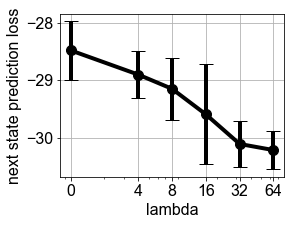

In [121]:
import matplotlib.pyplot as plt
import numpy as np

means = np.array([np.nanmean(loss) for loss in losses])
stds = np.array([np.nanstd(loss) for loss in losses])

lambda_svs_for_plot = [int(x) for x in lambda_svs]
lambda_svs_for_plot[0] = 1

plt.rcParams.update({'font.family': 'Arial', 'font.size': 16})
plt.figure(figsize=(4, 3))
plt.errorbar(lambda_svs_for_plot, means, yerr=stds, fmt='o-', capsize=7, linewidth=4, markersize=10, color="black")
plt.xlabel('lambda')
plt.xscale('log')
plt.ylabel(f'next state prediction loss')
#plt.title(f'epoch {calculate_loss_at_batch}')
plt.xticks(lambda_svs_for_plot, [int(x) for x in lambda_svs])
plt.grid(True)
plt.show()